In [2]:
import boto3
from botocore.config import Config
from botocore import UNSIGNED
import h5py
import pandas as pd
from io import BytesIO
import tables
import fsspec
import h5py
import numpy as np
import inspect
from scipy.fft import fft, fftfreq
import matplotlib.pyplot as plt

**boto3** es un SDK de AWS que permite utilizar los recursos de AWS desde Python.   

Aunque la base de datos que pasó Adrián (**Ocean Surface Wave Hindcast (US Wave)**) permite la descarga de ficheros individuales, estos siguen siendo de gran tamaño (apróximadamente 200GB cada uno), por lo que lo que se busca aquí es obtener partes más pequeñas de esos ficheros para estudiar el formato. 

### Listado de ficheros

In [7]:
# Configuramos boto3 para que no requiera autenticación
s3 = boto3.client('s3', config=Config(signature_version=UNSIGNED))

# Definición del contenedor en el que se encuentran los archivos
bucket_name = 'wpto-pds-us-wave'

# Listamos los archivos disponibles en el bucket
response = s3.list_objects_v2(Bucket=bucket_name)

dict_ficheros = {}

# Listamos los contenidos del bucket en caso de que estos existan
if 'Contents' in response:
    for obj in response['Contents']:
        url = obj['Key']
        directorios = url.split('/')
        
        # Agregar los archivos a dict_ficheros, agrupados por directorio
        if(directorios[1] not in dict_ficheros):
            dict_ficheros[directorios[1]] = [(url, obj['Size'])]
        else:
            dict_ficheros[directorios[1]].append((url, obj['Size']))
        
else:
    print("No se encontraron archivos en el bucket o prefijo especificado.")
    
# Mostrar los directorios con los archivos y sus tamaños
for clave, archivos in dict_ficheros.items():
    print(f'Directorio: {clave} ({len(archivos)} archivos)\n')
    
    for archivo, tamaño in archivos:
        tamaño_gb = tamaño / (1024 ** 3)
        print(f'\t - {archivo} ({tamaño_gb:.2f} GB)')
    print('\n')

Directorio: Alaska (32 archivos)

	 - v1.0.0/Alaska/Alaska_wave_1979.h5 (455.17 GB)
	 - v1.0.0/Alaska/Alaska_wave_1980.h5 (455.17 GB)
	 - v1.0.0/Alaska/Alaska_wave_1981.h5 (455.17 GB)
	 - v1.0.0/Alaska/Alaska_wave_1982.h5 (455.17 GB)
	 - v1.0.0/Alaska/Alaska_wave_1983.h5 (455.17 GB)
	 - v1.0.0/Alaska/Alaska_wave_1984.h5 (455.17 GB)
	 - v1.0.0/Alaska/Alaska_wave_1985.h5 (455.17 GB)
	 - v1.0.0/Alaska/Alaska_wave_1986.h5 (455.17 GB)
	 - v1.0.0/Alaska/Alaska_wave_1987.h5 (455.17 GB)
	 - v1.0.0/Alaska/Alaska_wave_1988.h5 (455.17 GB)
	 - v1.0.0/Alaska/Alaska_wave_1989.h5 (455.17 GB)
	 - v1.0.0/Alaska/Alaska_wave_1990.h5 (455.17 GB)
	 - v1.0.0/Alaska/Alaska_wave_1991.h5 (455.15 GB)
	 - v1.0.0/Alaska/Alaska_wave_1992.h5 (455.17 GB)
	 - v1.0.0/Alaska/Alaska_wave_1993.h5 (455.17 GB)
	 - v1.0.0/Alaska/Alaska_wave_1994.h5 (455.17 GB)
	 - v1.0.0/Alaska/Alaska_wave_1995.h5 (455.17 GB)
	 - v1.0.0/Alaska/Alaska_wave_1996.h5 (455.17 GB)
	 - v1.0.0/Alaska/Alaska_wave_1997.h5 (455.17 GB)
	 - v1.0.0/Alask

---

### Inspección del archivo

In [4]:
fs = fsspec.filesystem('s3', anon=True)
s3_url = 's3://wpto-pds-us-wave/v1.0.0/Hawaii/Hawaii_wave_1979.h5'

with fs.open(s3_url, 'rb') as f:
    with h5py.File(f, 'r') as h5file:
        print("Atributos a nivel del archivo:")
        for key, value in h5file.attrs.items():
            print(f"{key}: {value}")
            
        
        def inspect_group(group, prefix=''):
            for name, obj in group.items():
                if isinstance(obj, h5py.Group):
                    print(f"{prefix}/{name} (Grupo)")
                    inspect_group(obj, prefix=f"{prefix}/{name}")
                elif isinstance(obj, h5py.Dataset):
                    print(f"{prefix}/{name} (Dataset)")
                    print(f"  Shape: {obj.shape}, Dtype: {obj.dtype}")
                    # Si el dataset tiene atributos:
                    for attr_key, attr_value in obj.attrs.items():
                        print(f"  Atributo {attr_key}: {attr_value}")

        print("\nEstructura del archivo HDF5:")
        inspect_group(h5file)

Atributos a nivel del archivo:
ref_IEC62600-101: International Electrotechnical Commission, Marine energy - Wave, tidal and other water current converters - Part 101: Wave energy resource assessment and characterization, Technical Specification 62600–101, 2015.
ref_SWAN-Manual: SWAN Team, SWAN: User Manual, Delft University of Technology, Delft, The Netherlands, Cycle III Version 41.31, 2019.
ref_Wu-Wang-Yang-Garcia-Medina-2020: W.C. Wu, T. Wang, Z. Yang, and G. García-Medina, “Development and validation of a high-resolution regional wave hindcast model for U.S. West Coast wave resource characterization,” Renewable Energy, vol. 152, pp. 736–753, Jun. 2020.
source: PNNL2019
version: v1.0.0

Estructura del archivo HDF5:
/coordinates (Dataset)
  Shape: (700414, 2), Dtype: float32
  Atributo description: (latitude, longitude) using Datum: NAD83
  Atributo dimensions: ['position']
  Atributo src_name: (Xp, Yp)
  Atributo units: (deg, deg)
/directionality_coefficient (Dataset)
  Shape: (2872

### Se imprimen las variables almacenadas en cada uno de los archivos

In [13]:
fs = fsspec.filesystem('s3', anon=True)

for clave, urls in dict_ficheros.items():
    if(clave != 'virtual_buoy'):
        url = dict_ficheros[clave][-1][0]
        s3_url = 's3://wpto-pds-us-wave/' + url
        print(f'Directorio: {clave}')
        # Abrir el archivo HDF5 remotamente usando fsspec
        with fs.open(s3_url, 'rb') as f:
            with h5py.File(f, 'r') as hdf:
                keys = list(hdf.keys())
                for key in keys:
                    print(hdf[key])
    else:
        url = dict_ficheros[clave][-2][0]
        s3_url = 's3://wpto-pds-us-wave/' + url
        print(f'Directorio: {clave}')
        # Abrir el archivo HDF5 remotamente usando fsspec
        with fs.open(s3_url, 'rb') as f:
            with h5py.File(f, 'r') as hdf:
                keys = list(hdf.keys())
                for key in keys:
                    print(hdf[key])
    print('\n')

Directorio: Alaska
<HDF5 dataset "coordinates": shape (3894283, 2), type "<f4">
<HDF5 dataset "directionality_coefficient": shape (2920, 3894283), type "<f4">
<HDF5 dataset "energy_period": shape (2920, 3894283), type "<f4">
<HDF5 dataset "maximum_energy_direction": shape (2920, 3894283), type "<f4">
<HDF5 dataset "mean_absolute_period": shape (2920, 3894283), type "<f4">
<HDF5 dataset "mean_wave_direction": shape (2920, 3894283), type "<f4">
<HDF5 dataset "mean_zero-crossing_period": shape (2920, 3894283), type "<f4">
<HDF5 dataset "meta": shape (3894283,), type "|V27">
<HDF5 dataset "omni-directional_wave_power": shape (2920, 3894283), type "<f4">
<HDF5 dataset "peak_period": shape (2920, 3894283), type "<f4">
<HDF5 dataset "significant_wave_height": shape (2920, 3894283), type "<f4">
<HDF5 dataset "spectral_width": shape (2920, 3894283), type "<f4">
<HDF5 dataset "time_index": shape (2920,), type "|S25">
<HDF5 dataset "water_depth": shape (3894283,), type "<f4">


Directorio: Atlant

### Se intenta buscar información sobre estos datasets dentro del archivo

In [15]:
fs = fsspec.filesystem('s3', anon=True)
s3_url = 's3://wpto-pds-us-wave/v1.0.0/Hawaii/Hawaii_wave_1979.h5'

with fs.open(s3_url, 'rb') as f:
    with h5py.File(f, 'r') as hdf:
        keys = list(hdf.keys())
        for key in keys:
            print(hdf[key])

            if hdf[key].attrs:
                print(f'\nAtributos')

                for attr_name, attr_value in hdf[key].attrs.items():
                    print(f"\t{attr_name}: {attr_value}")
            
            print('\n----------------------------------------------------------------------\n')

<HDF5 dataset "coordinates": shape (700414, 2), type "<f4">

Atributos
	description: (latitude, longitude) using Datum: NAD83
	dimensions: ['position']
	src_name: (Xp, Yp)
	units: (deg, deg)

----------------------------------------------------------------------

<HDF5 dataset "directionality_coefficient": shape (2872, 700414), type "<f4">

Atributos
	IEC_name: d
	SWAN_name: 
	description: Fraction of total wave energy travelling in the "direction of maximum wave power" direction
	dimensions: ['time' 'position']
	units: 

----------------------------------------------------------------------

<HDF5 dataset "energy_period": shape (2872, 700414), type "<f4">

Atributos
	IEC_name: T_e
	SWAN_name: TM02
	description: Spectral width characterizes the relative spreading of energy in the wave spectrum. Large values indicate a wider spectral peak
	dimensions: ['time' 'position']
	units: s

----------------------------------------------------------------------

<HDF5 dataset "maximum_energy": sh

### Descarga de archivos

In [9]:
s3_url = 's3://wpto-pds-us-wave/v1.0.0/Hawaii/Hawaii_wave_1979.h5'

fs = fsspec.filesystem('s3', anon=True)

# Abrir el archivo HDF5 remotamente usando fsspec
with fs.open(s3_url, 'rb') as f:
    with h5py.File(f, 'r') as hdf:
        coordinates = hdf['coordinates'][0:10] 
        directionality_coefficient = hdf['directionality_coefficient'][:, 0:10] 
        energy_period = hdf['energy_period'][:, 0:10]   
        maximum_energy = hdf['maximum_energy'][:, 0:10]   
        maximum_energy_direction = hdf['maximum_energy_direction'][:, 0:10]   
        mean_absolute_period = hdf['mean_absolute_period'][:, 0:10]  
        mean_wave_direction = hdf['mean_wave_direction'][:, 0:10]  
        meta = hdf['meta'][0:10]
        omni_directional_wave_power = hdf['omni-directional_wave_power'][:, 0:10]
        peak_period = hdf['peak_period'][:, 0:10]
        significant_wave_height = hdf['significant_wave_height'][:, 0:10]
        spectral_width = hdf['spectral_width'][:, 0:10]
        time_index = hdf['time_index'] 
        water_depth = hdf['water_depth'][0:10] 

        # Crear DataFrames para cada uno de los demás datasets
        df_coordinates = pd.DataFrame(coordinates)
        df_directionality_coefficient = pd.DataFrame(directionality_coefficient)
        df_energy_period = pd.DataFrame(energy_period)
        df_maximum_energy = pd.DataFrame(maximum_energy)
        df_maximum_energy_direction = pd.DataFrame(maximum_energy_direction)
        df_mean_absolute_period = pd.DataFrame(mean_absolute_period)
        df_mean_wave_direction = pd.DataFrame(mean_wave_direction)
        df_meta = pd.DataFrame(meta)
        df_omni_directional_wave_power = pd.DataFrame(omni_directional_wave_power)
        df_peak_period = pd.DataFrame(peak_period)
        df_significant_wave_height = pd.DataFrame(significant_wave_height)
        df_spectral_width = pd.DataFrame(spectral_width)
        df_time_index = pd.DataFrame(time_index)
        df_water_depth = pd.DataFrame(water_depth)

        # Exportar cada DataFrame a un archivo CSV
        #df_coordinates.to_csv('df_coordinates.csv', index=False)
        df_coordinates.to_csv('./data/df_coordinates.csv', index=False)
        df_meta.to_csv('./data/df_meta.csv', index=False)
        df_directionality_coefficient.to_csv('./data/df_directionality_coefficient.csv', index=False)
        df_energy_period.to_csv('./data/df_energy_period.csv', index=False)
        df_significant_wave_height.to_csv('./data/df_significant_wave_height.csv', index=False)
        df_maximum_energy.to_csv('./data/df_maximum_energy.csv', index=False)
        df_maximum_energy_direction.to_csv('./data/df_maximum_energy_direction.csv', index=False)
        df_mean_absolute_period.to_csv('./data/df_mean_absolute_period.csv', index=False)
        df_mean_wave_direction.to_csv('./data/df_mean_wave_direction.csv', index=False)
        df_omni_directional_wave_power.to_csv('./data/df_omni_directional_wave_power.csv', index=False)
        df_peak_period.to_csv('./data/df_peak_period.csv', index=False)
        df_spectral_width.to_csv('./data/df_spectral_width.csv', index=False)
        df_time_index.to_csv('./data/df_time_index.csv', index=False)
        df_water_depth.to_csv('./data/df_water_depth.csv', index=False)

        print("Archivos CSV exportados correctamente.")

Archivos CSV exportados correctamente.


---

### Creación de un dataframe completo  

En el dataframe *time_index*, se almacenan $X$ registros temporales (un registro por cada 3 horas).  
En el de *coordenadas* hay $Y$ filas. De esta forma, para cada registro temporal $X_i$ se registran datos de $Y$ localizaciones. 

Por lo tanto hay que replicar cada registro temporal para cada una de las localizaciones

In [63]:
time_index = pd.read_csv('./data/df_time_index.csv')
coordinates = pd.read_csv('./data/df_coordinates.csv')
dir_coef = pd.read_csv('./data/df_directionality_coefficient.csv')
energy_T = pd.read_csv('./data/df_energy_period.csv')
max_energy = pd.read_csv('./data/df_maximum_energy.csv')
max_energy_dir = pd.read_csv('./data/df_maximum_energy_direction.csv')
mean_absolute_T = pd.read_csv('./data/df_mean_absolute_period.csv')
mean_wave_dir = pd.read_csv('./data/df_mean_wave_direction.csv')
onmi_dir_wave_pow = pd.read_csv('./data/df_omni_directional_wave_power.csv')
peak_T = pd.read_csv('./data/df_peak_period.csv')
significant_wave_H = pd.read_csv('./data/df_significant_wave_height.csv')
spectral_width = pd.read_csv('./data/df_spectral_width.csv')
water_depth = pd.read_csv('./data/df_water_depth.csv')

In [64]:
# Definimos una función para la creación de un dataframe definitivo
def crear_df(time_index, coordinates, water_depth, dir_coef, energy_T, 
             max_energy, max_energy_dir, mean_absolute_T, 
             mean_wave_dir, onmi_dir_wave_pow, peak_T, significant_wave_H, 
             spectral_width):
    
    # Transformación de los valores de 'time_index' a fechas
    time_index['0'] = time_index['0'].apply(lambda x: pd.to_datetime(x.strip('b')))
    time_index.rename(columns={'0':'indice_tiempo'}, inplace=True)
    
    # Añadimos una columna 'localizacion' que actua como id de cada par (latitud, longitud)
    # lo que facilitará el posterior acceso a los datos
    coordinates = coordinates.reset_index()
    coordinates.rename(columns={'0':'latitud', '1':'longitud', 'index':'id_localizacion'}, inplace=True)
    
    # Miramos cuantas localizaciones hay almacenadas para saber cuantas veces hay que replicar el índice temporal
    registros_cor = len(coordinates)
    registros_tiempo = len(time_index)
    time_index = time_index.loc[time_index.index.repeat(registros_cor)].reset_index(drop=True)
    
    # Se replican también las localizaciones
    coordinates = pd.DataFrame(np.tile(coordinates.values, (registros_tiempo, 1)), columns=coordinates.columns)
    
    water_depth.rename(columns={'0':'water_depth'}, inplace=True)
    water_depth = pd.DataFrame(np.tile(water_depth.values, (registros_tiempo, 1)), columns=water_depth.columns)
    
    df = pd.concat([time_index, coordinates], axis=1)
    
    # Añadimos las demás variables al dataframe
    argumentos = list(inspect.signature(crear_df).parameters)
    
    for i in range(3, len(argumentos)):
        caracteristica = argumentos[i]
    
        # Se aplanan los valores de la variable y los añadimos como una nueva columna
        add_car = pd.DataFrame(locals()[caracteristica].values.ravel(), columns=[f'{caracteristica}'])
        df = pd.concat([df, add_car], axis=1)
    
    df = pd.concat([df, water_depth], axis=1)
    
    df['id_localizacion'] = df['id_localizacion'].astype(int)
    
    return df

In [65]:
df = crear_df(time_index, coordinates, water_depth, dir_coef, energy_T, 
             max_energy, max_energy_dir, mean_absolute_T, 
             mean_wave_dir, onmi_dir_wave_pow, peak_T, significant_wave_H, 
             spectral_width) 

In [66]:
df

,indice_tiempo,id_localizacion,latitud,longitud,dir_coef,energy_T,max_energy,max_energy_dir,mean_absolute_T,mean_wave_dir,onmi_dir_wave_pow,peak_T,significant_wave_H,spectral_width,water_depth
0,1979-01-07 00:00:00+00:00,0,15.0,-164.00000,0.641829,9.3742,17643.0,303.75,7.6818,15.978,27488.0,11.8381,2.44580,0.35875,5533.0000
1,1979-01-07 00:00:00+00:00,1,15.0,-163.95367,0.643669,9.3986,17747.0,303.75,7.7147,15.384,27572.0,11.8381,2.44631,0.35680,5546.7950
2,1979-01-07 00:00:00+00:00,2,15.0,-163.90735,0.644472,9.4061,17800.0,303.75,7.7211,15.173,27619.0,11.8381,2.44742,0.35658,5577.1514
3,1979-01-07 00:00:00+00:00,3,15.0,-163.86101,0.645165,9.4120,17841.0,303.75,7.7250,14.992,27654.0,11.8381,2.44818,0.35652,5616.1040
4,1979-01-07 00:00:00+00:00,4,15.0,-163.81468,0.645752,9.4172,17873.0,303.75,7.7280,14.837,27678.0,11.8381,2.44859,0.35649,5672.6220
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28715,1979-12-31 21:00:00+00:00,5,15.0,-163.76834,0.846873,11.3934,33585.0,266.25,9.3610,10.128,39657.0,13.0063,2.66423,0.33271,5717.1960
28716,1979-12-31 21:00:00+00:00,6,15.0,-163.72200,0.845817,11.3850,33336.0,266.25,9.3545,10.059,39413.0,13.0063,2.65699,0.33302,5681.6846
28717,1979-12-31 21:00:00+00:00,7,15.0,-163.67566,0.844915,11.3796,33131.0,266.25,9.3507,9.983,39212.0,13.0063,2.65085,0.33326,5623.9360
28718,1979-12-31 21:00:00+00:00,8,15.0,-163.62932,0.844219,11.3779,32981.0,266.25,9.3506,9.900,39067.0,13.0063,2.64612,0.33340,5616.0000


In [67]:
df.to_csv('hawaii_completo_prueba.csv', index=False)

A la hora de realizar el espectro de con la transformada de Fourier, me aparecen algunas dudas:  
- No sabemos la frecuencia de muestreo con la que fueron recogidas las muestras, por lo que no se podría modela el vector de tiempo no las frecuencias.  
- Se aproxima la señal a una sinusoidal pero no tendría qeu ser así ¿?

---

### Funciones PM, JONSWAP, Ochi_Hubble

In [4]:
import waveresponse as wr

Text(0.5, 1.0, 'Pearson-Moskowitz')

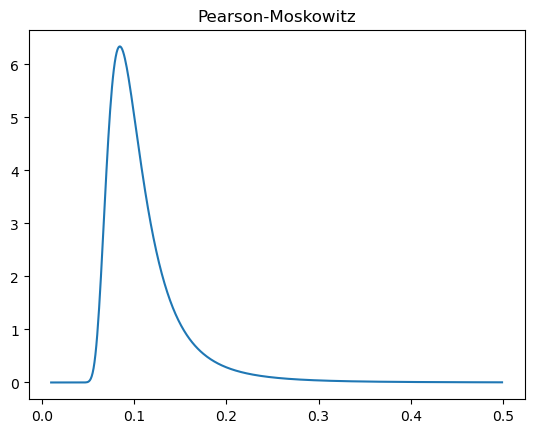

In [39]:
freq = np.arange(0.01, 0.5, 0.001)
spectrum = wr.ModifiedPiersonMoskowitz(freq, freq_hz=True)

hs = 2.44580
tp = 11.8381
freq, vals = spectrum(hs, tp)

plt.plot(freq, vals)
plt.title("Pearson-Moskowitz")

Text(0.5, 1.0, 'JONSWAP')

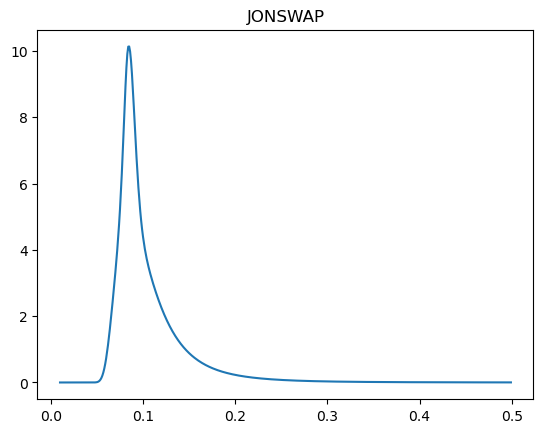

In [34]:
freq = np.arange(0.01, 0.5, 0.001)
spectrum = wr.JONSWAP(freq, freq_hz=True)

hs = 2.44580
tp = 11.8381
freq, vals = spectrum(hs, tp, gamma=2)

plt.plot(freq, vals)
plt.title("JONSWAP")